# Lets Predict Diamond Priceusing Regression and use the concept of RANSAC regressor and see does it make any difference

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sks
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RANSACRegressor
from sklearn.metrics import r2_score,median_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,RobustScaler,PowerTransformer,QuantileTransformer,MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir diamonddata
!kaggle datasets download -d shivam2503/diamonds
!unzip diamonds.zip -d diamonddata

Saving kaggle.json to kaggle.json
  0% 0.00/733k [00:00<?, ?B/s]
100% 733k/733k [00:00<00:00, 73.5MB/s]
Archive:  diamonds.zip
  inflating: diamonddata/diamonds.csv  


# Lets load so called diamond data

In [3]:
dataset = pd.read_csv('/content/diamonddata/diamonds.csv')
dataset = dataset.iloc[:,1:]
dataset.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## About dataset

* This classic dataset contains the prices and other attributes of almost 54,000 diamonds. There are 10 attributes included in the dataset including the target ie. price.

## Feature description:

* price price in US dollars ($326--$18,823)This is the target column containing tags for the features. 

## The 4 Cs of Diamonds:-

* carat (0.2--5.01) The carat is the diamond’s physical weight measured in metric carats.  One carat equals 1/5 gram and is subdivided into 100 points. Carat weight is the most objective grade of the 4Cs. 

* cut (Fair, Good, Very Good, Premium, Ideal) In determining the quality of the cut, the diamond grader evaluates the cutter’s skill in the fashioning of the diamond. The more precise the diamond is cut, the more captivating the diamond is to the eye.  

* color, from J (worst) to D (best) The colour of gem-quality diamonds occurs in many hues. In the range from colourless to light yellow or light brown. Colourless diamonds are the rarest. Other natural colours (blue, red, pink for example) are known as "fancy,” and their colour grading is different than from white colorless diamonds.  

* clarity (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) Diamonds can have internal characteristics known as inclusions or external characteristics known as blemishes. Diamonds without inclusions or blemishes are rare; however, most characteristics can only be seen with magnification.  

## Dimensions

* x length in mm (0--10.74)

* y width in mm (0--58.9)

* z depth in mm (0--31.8)

<center><img src="https://4cs.gia.edu/wp-content/uploads/2017/05/Hero_Cut_700x394.jpg"></center>

* depth $\ totaldepthpercentage = z / mean(x, y) = 2 * z / (x + y)$ (43--79) The depth of the diamond is its height (in millimetres) measured from the culet (bottom tip) to the table (flat, top surface).

* table width of the top of the diamond relative to widest point (43--95)

* A diamond's table refers to the flat facet of the diamond seen when the stone is face up. The main purpose of a diamond table is to refract entering light rays and allow reflected light rays from within the diamond to meet the observer’s eye. The ideal table cut diamond will give the diamond stunning fire and brilliance.

# lets do some EDA

In [4]:
dataset.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Null values
* No Nulls

In [5]:
dataset.isna().sum().sum()

0

## Lets see the correlation of the independent variables to dependent variables

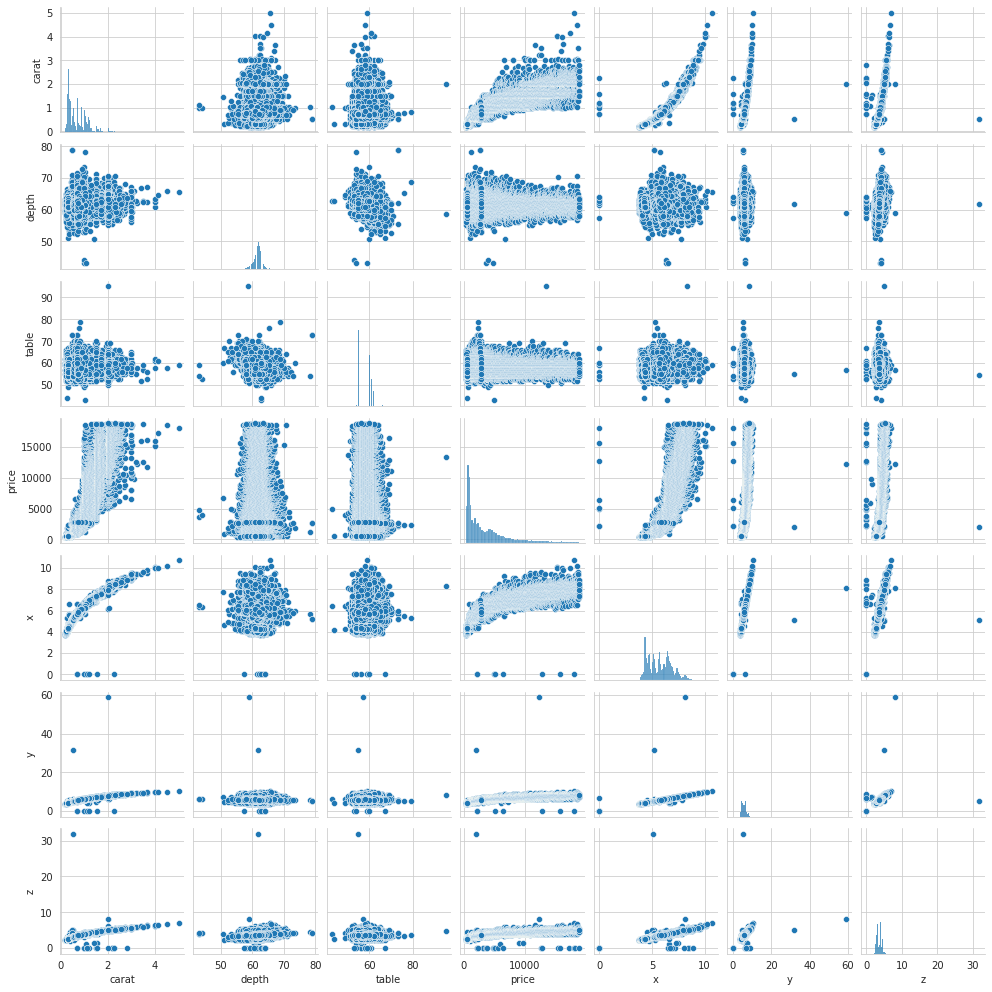

In [6]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(dataset, height=2);
plt.show()

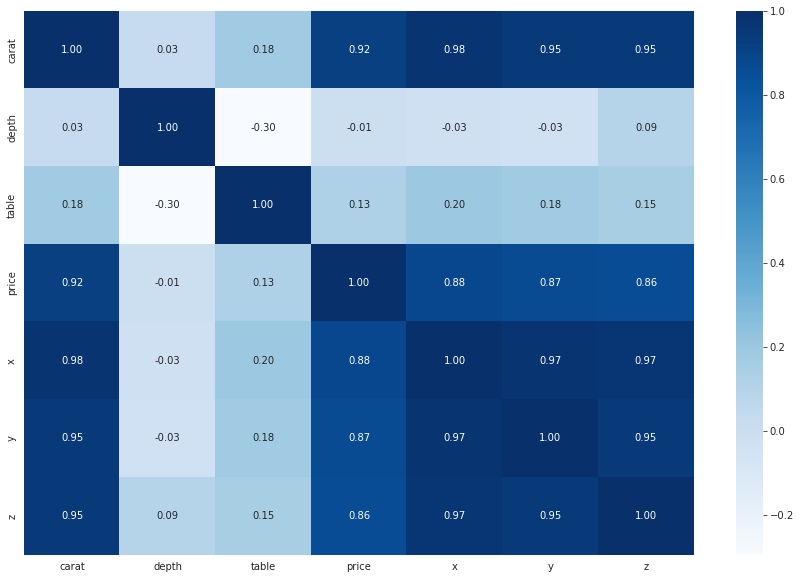

In [7]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(dataset.corr(),annot = True,cmap = 'Blues',fmt = '.2f')

## Observations

* We can see that price is highly correlated with carat,x,y,z dimensions.
* but dimensions and carats are also highly correlated with each other which is not a good sign.
* We have few outliers aswell.

In [8]:
# Get list of categorical variables
s = (dataset.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [9]:
# Get list of numerical variables
s = (dataset.dtypes !="object")
numeric_cols = list(s[s].index)
print("numerical variables:")
numeric_cols.remove('price')
print(numeric_cols)

numerical variables:
['carat', 'depth', 'table', 'x', 'y', 'z']




****************************************************************************************************
                                                  cut                                                  
****************************************************************************************************



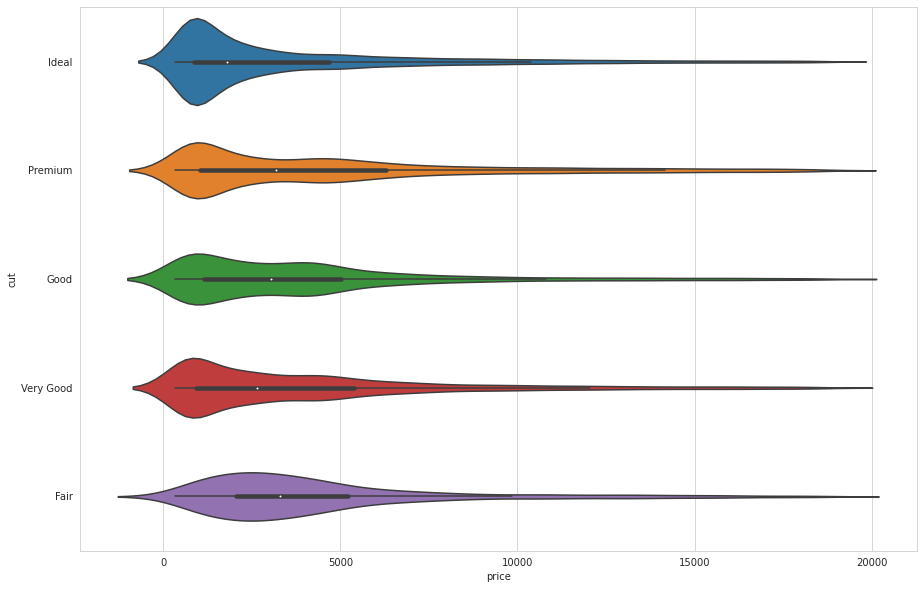



****************************************************************************************************
                                                  color                                                  
****************************************************************************************************



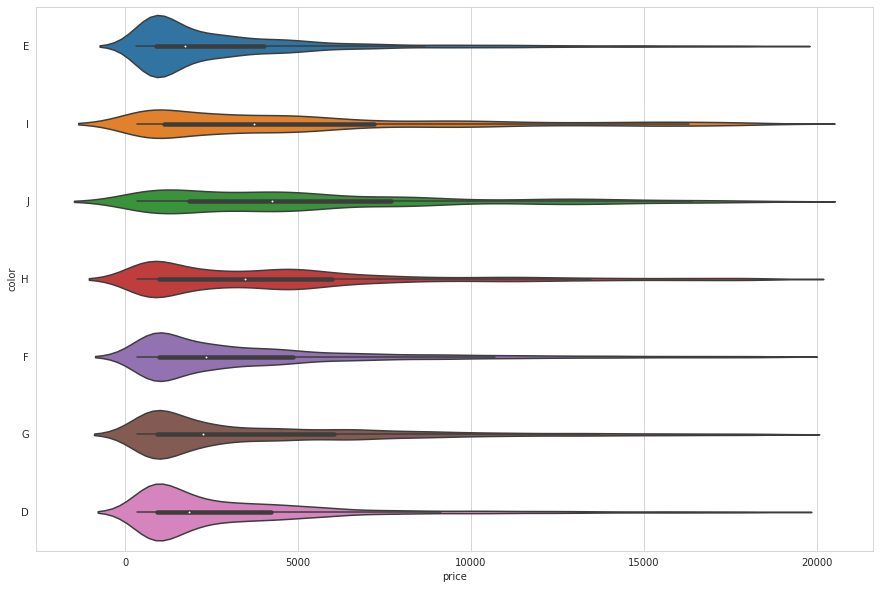



****************************************************************************************************
                                                  clarity                                                  
****************************************************************************************************



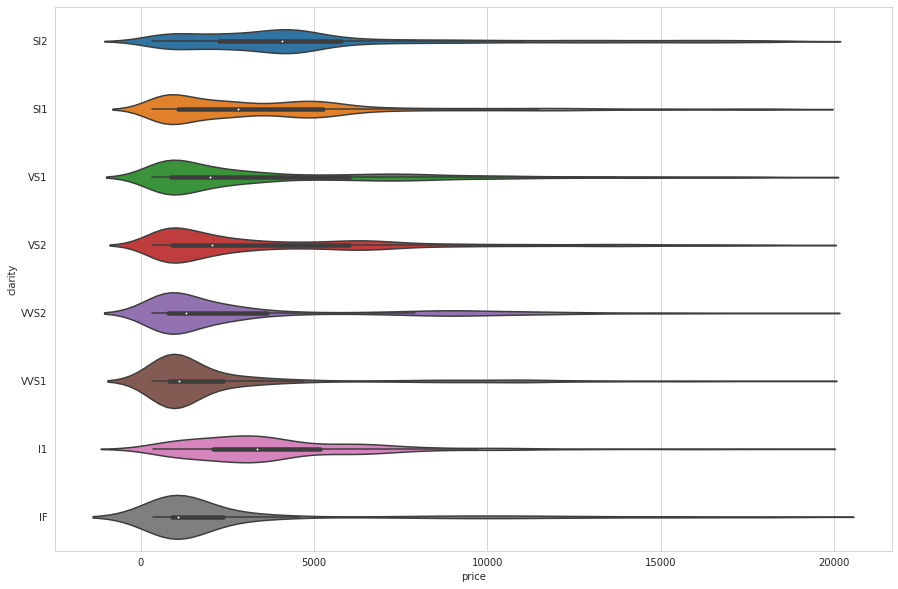

In [10]:
for column in object_cols:
  print()
  print()
  print("*"*100)
  print(" "* 50 + column + " "* 50)
  print("*"*100)
  print()
  fig, ax = plt.subplots(figsize=(15,10)) 
  sns.violinplot(data= dataset, x="price", y=column)
  plt.show()

### Lets do preprocesing 

In [11]:
dataset.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### Train Test Split with 80 and 20 

In [12]:
X_train,X_test,y_train,y_test = train_test_split(dataset.drop(['price'],axis = 1),dataset['price'],test_size = 0.2,random_state = 42)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(43152, 9)
(10788, 9)
(43152,)
(10788,)


dataset_for_eda = dataset.copy()

dataset_for_eda.cut.map({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4})

dataset_for_eda.color.map({'D':6, 'E':5, 'F':4, 'G':3, 'H':2, 'I':1, 'j':0})

dataset_for_eda.clarity.map({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3,'VS1':4, 'VVS2':5,'VVS1':6,'IF':7})

### Lets create result dataset

In [128]:
result_dataset = pd.DataFrame(data =np.zeros((6,16)) , index = ['r2_score','adjusted_r2_score','median_absolute_error','mean_squared_error','mean_absolute_percentage_error','mean_absolute_error'],columns = ['KNN','KNN_RANSAC','LR','LR_RANSAC','LASSO','LASSO_RANSAC','RIDGE','RIDGE_RANSAC','ELASTIC','ELASTIC_RANSAC','SVR','SVR_RANSAC','DT','DT_RANSAC','RF','GBDT',])
result_dataset

,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
def metrics(y_true,y_pred,model = 'KNN'):
  r2_scores = r2_score(y_true,y_pred)
  p = 13 # number of features in the test dataset
  adjusted_r2_scores = 1- (1- r2_score(y_true,y_pred))*(len(y_true)-1)/(len(y_true)-p-1)
  median_absolute_errors = median_absolute_error(y_true,y_pred)
  mean_squared_errors = mean_squared_error(y_true,y_pred)
  mean_absolute_percentage_errors = mean_absolute_percentage_error(y_true,y_pred)
  mean_absolute_errors = mean_absolute_error(y_true,y_pred)
  result_dataset[model]['r2_score'] = r2_scores
  result_dataset[model]['adjusted_r2_score'] = adjusted_r2_scores
  result_dataset[model]['median_absolute_error'] = median_absolute_errors
  result_dataset[model]['mean_squared_error'] = mean_squared_errors
  result_dataset[model]['mean_absolute_percentage_error'] = mean_absolute_percentage_errors
  result_dataset[model]['mean_absolute_error'] = mean_absolute_errors
  print('r2_score for '+ model + " :" + str(r2_scores))
  print('adjusted_r2_score for '+ model + " :" + str(adjusted_r2_scores)) # Adj r2 = 1-(1-R2)*(n-1)/(n-p-1) Where n is the sample size and p is the number of independent variables.
  print('median_absolute_error for '+ model + " :" + str(median_absolute_errors))
  print('mean_squared_error for '+ model + " :" + str(mean_squared_errors))
  print('mean_absolute_percentage_error for '+ model + " :" + str(mean_absolute_percentage_errors))
  print('mean_absolute_error for '+ model + " :" + str(mean_absolute_errors))

In [70]:
numerical_pipe = Pipeline([('QuantileTransformer',QuantileTransformer(output_distribution='normal')),('StandardScaler', StandardScaler())])
ordinal = ColumnTransformer([('ordinalencoding', OrdinalEncoder(categories = [['Fair','Good','Very Good','Premium','Ideal'],['J','I','H','G','F','E','D'],['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']]), object_cols),('numerical_pipe',numerical_pipe,numeric_cols)],remainder='drop')


## Lets start with KNN

In [76]:
knn_params = {'model__n_neighbors' : [1, 2, 3, 4, 5]}
knn_pipe = Pipeline([('ordinal', ordinal),('model', KNeighborsRegressor())])
knn_grid = GridSearchCV(estimator=knn_pipe, param_grid=knn_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
knn_grid.fit(X_train, y_train)
knn_grid.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ...............................model__n_neighbors=1; total time=   0.6s
[CV] END ...............................model__n_neighbors=1; total time=   0.6s
[CV] END ...............................model__n_neighbors=2; total time=   0.7s
[CV] END ...............................model__n_neighbors=2; total time=   0.7s
[CV] END ...............................model__n_neighbors=3; total time=   0.8s
[CV] END ...............................model__n_neighbors=3; total time=   0.8s
[CV] END ...............................model__n_neighbors=4; total time=   0.9s
[CV] END ...............................model__n_neighbors=4; total time=   0.8s
[CV] END ...............................model__n_neighbors=5; total time=   0.9s
[CV] END ...............................model__n_neighbors=5; total time=   0.8s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', KNeighborsRegressor())])

In [129]:
y_pred = knn_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'KNN')
result_dataset

r2_score for KNN :0.9641207985765
adjusted_r2_score for KNN :0.9640775064270193
median_absolute_error for KNN :172.5999999999999
mean_squared_error for KNN :570365.2588431591
mean_absolute_percentage_error for KNN :0.11589235944122937
mean_absolute_error for KNN :413.8895439377086


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
pd.DataFrame(np.column_stack((np.array(y_test),np.array(y_pred)))).head(20)

,0,1
0,559.0,572.8
1,2201.0,2427.6
2,1238.0,1083.4
3,1304.0,1212.4
4,6901.0,10583.4
5,3011.0,3845.2
6,1765.0,1881.2
7,1679.0,1829.4
8,2102.0,2398.6
9,4789.0,6664.8


## lets do with RANSAC

In [93]:
knn_ransac_params = {'model__base_estimator__n_neighbors' : [1, 2, 3, 4, 5]}
knn_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(KNeighborsRegressor()))])
knn_ransac_grid = GridSearchCV(estimator=knn_ransac_pipe, param_grid=knn_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
knn_ransac_grid.fit(X_train, y_train)
knn_ransac_grid.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ...............model__base_estimator__n_neighbors=1; total time=   1.7s
[CV] END ...............model__base_estimator__n_neighbors=1; total time=   1.3s
[CV] END ...............model__base_estimator__n_neighbors=2; total time=   1.7s
[CV] END ...............model__base_estimator__n_neighbors=2; total time=   1.7s
[CV] END ...............model__base_estimator__n_neighbors=3; total time=   1.8s
[CV] END ...............model__base_estimator__n_neighbors=3; total time=   1.8s
[CV] END ...............model__base_estimator__n_neighbors=4; total time=   2.3s
[CV] END ...............model__base_estimator__n_neighbors=4; total time=   2.0s
[CV] END ...............model__base_estimator__n_neighbors=5; total time=   3.4s
[CV] END ...............model__base_estimator__n_neighbors=5; total time=   2.9s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=KNeighborsRegressor(n_neighbors=1)))])

In [130]:
y_pred = knn_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'KNN_RANSAC')
result_dataset

r2_score for KNN_RANSAC :0.8006484928873805
adjusted_r2_score for KNN_RANSAC :0.8004079536640221
median_absolute_error for KNN_RANSAC :223.0
mean_squared_error for KNN_RANSAC :3169055.3146088244
mean_absolute_percentage_error for KNN_RANSAC :0.185581932402179
mean_absolute_error for KNN_RANSAC :857.2091212458287


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
pd.DataFrame(np.column_stack((np.array(y_test),np.array(y_pred)))).head(20)

,0,1
0,559.0,559.0
1,2201.0,2351.0
2,1238.0,1158.0
3,1304.0,1833.0
4,6901.0,5497.0
5,3011.0,2815.0
6,1765.0,1680.0
7,1679.0,1787.0
8,2102.0,2578.0
9,4789.0,7810.0


## Lets Apply Linear Regression

In [97]:
Linear_params = {}
Linear_pipe = Pipeline([('ordinal', ordinal),('model', LinearRegression())])
Linear_grid = GridSearchCV(estimator=Linear_pipe, param_grid=Linear_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Linear_grid.fit(X_train, y_train)
Linear_grid.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', LinearRegression())])

In [131]:
y_pred = Linear_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'LR')
result_dataset

r2_score for LR :0.7585654571246684
adjusted_r2_score for LR :0.7582741401525708
median_absolute_error for LR :1192.8689625419593
mean_squared_error for LR :3838041.8202556316
mean_absolute_percentage_error for LR :1.0173111414329985
mean_absolute_error for LR :1478.5920287046315


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
pd.DataFrame(np.column_stack((np.array(y_test),np.array(y_pred)))).head(20)

,0,1
0,559.0,-3858.930009
1,2201.0,4315.151869
2,1238.0,2778.852860
3,1304.0,3297.800030
4,6901.0,8707.975636
5,3011.0,4829.659038
6,1765.0,3250.589743
7,1679.0,3308.111635
8,2102.0,3805.004222
9,4789.0,6509.701430


## lets do with RANSAC

In [100]:
Linear_ransac_params = {}
Linear_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(LinearRegression()))])
Linear_ransac_grid = GridSearchCV(estimator=Linear_ransac_pipe, param_grid=Linear_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Linear_ransac_grid.fit(X_train, y_train)
Linear_ransac_grid.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', RANSACRegressor(base_estimator=LinearRegression()))])

In [132]:
y_pred = Linear_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'LR_RANSAC')
result_dataset

r2_score for LR_RANSAC :0.476850872014413
adjusted_r2_score for LR_RANSAC :0.47621963582879834
median_absolute_error for LR_RANSAC :773.9611638904569
mean_squared_error for LR_RANSAC :8316408.279969042
mean_absolute_percentage_error for LR_RANSAC :0.5510971026590175
mean_absolute_error for LR_RANSAC :1668.676420497671


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Lets Apply Lasso Regression

In [103]:
Lasso_params = {'model__alpha' : [0.0001, 0.001, 0.00001,0.1,0.01]}
Lasso_pipe = Pipeline([('ordinal', ordinal),('model', Lasso(random_state = 42))])
Lasso_grid = GridSearchCV(estimator=Lasso_pipe, param_grid=Lasso_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Lasso_grid.fit(X_train, y_train)
Lasso_grid.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ................................model__alpha=0.0001; total time=   0.4s
[CV] END ................................model__alpha=0.0001; total time=   0.4s
[CV] END .................................model__alpha=0.001; total time=   0.5s
[CV] END .................................model__alpha=0.001; total time=   0.4s
[CV] END .................................model__alpha=1e-05; total time=   0.4s
[CV] END .................................model__alpha=1e-05; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.4s
[CV] END ..................................model__alpha=0.01; total time=   0.4s
[CV] END ..................................model__alpha=0.01; total time=   0.4s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', Lasso(alpha=0.1, random_state=42))])

In [133]:
y_pred = Lasso_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'LASSO')
result_dataset

r2_score for LASSO :0.7585656068072414
adjusted_r2_score for LASSO :0.7582742900157521
median_absolute_error for LASSO :1192.7868218350006
mean_squared_error for LASSO :3838039.440778494
mean_absolute_percentage_error for LASSO :1.0172576570649072
mean_absolute_error for LASSO :1478.5942006246735


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## lets do with RANSAC

In [105]:
Lasso_ransac_params = {'model__base_estimator__alpha' : [0.0001, 0.001, 0.00001,0.1,0.01]}
Lasso_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(Lasso(random_state = 42)))])
Lasso_ransac_grid = GridSearchCV(estimator=Lasso_ransac_pipe, param_grid=Lasso_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Lasso_ransac_grid.fit(X_train, y_train)
Lasso_ransac_grid.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ................model__base_estimator__alpha=0.0001; total time=   2.1s
[CV] END ................model__base_estimator__alpha=0.0001; total time=   0.7s
[CV] END .................model__base_estimator__alpha=0.001; total time=   0.7s
[CV] END .................model__base_estimator__alpha=0.001; total time=   0.7s
[CV] END .................model__base_estimator__alpha=1e-05; total time=   0.7s
[CV] END .................model__base_estimator__alpha=1e-05; total time=   0.7s
[CV] END ...................model__base_estimator__alpha=0.1; total time=   0.7s
[CV] END ...................model__base_estimator__alpha=0.1; total time=   0.6s
[CV] END ..................model__base_estimator__alpha=0.01; total time=   0.7s
[CV] END ..................model__base_estimator__alpha=0.01; total time=   0.7s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=Lasso(alpha=0.001,
                                                      random_state=42)))])

In [134]:
y_pred = Lasso_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'LASSO_RANSAC')
result_dataset

r2_score for LASSO_RANSAC :0.6333075514758215
adjusted_r2_score for LASSO_RANSAC :0.6328650972498318
median_absolute_error for LASSO_RANSAC :693.8142766599804
mean_squared_error for LASSO_RANSAC :5829244.381714072
mean_absolute_percentage_error for LASSO_RANSAC :1.000222638617933
mean_absolute_error for LASSO_RANSAC :1493.061311014832


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Lets Apply Ridge Regression

In [107]:
Ridge_params = {'model__alpha' : [1.0,0.001,0.1,0.01]}
Ridge_pipe = Pipeline([('ordinal', ordinal),('model', Ridge(random_state = 42))])
Ridge_grid = GridSearchCV(estimator=Ridge_pipe, param_grid=Ridge_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Ridge_grid.fit(X_train, y_train)
Ridge_grid.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ...................................model__alpha=1.0; total time=   0.2s
[CV] END ...................................model__alpha=1.0; total time=   0.2s
[CV] END .................................model__alpha=0.001; total time=   0.2s
[CV] END .................................model__alpha=0.001; total time=   0.2s
[CV] END ...................................model__alpha=0.1; total time=   0.2s
[CV] END ...................................model__alpha=0.1; total time=   0.2s
[CV] END ..................................model__alpha=0.01; total time=   0.2s
[CV] END ..................................model__alpha=0.01; total time=   0.2s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', Ridge(random_state=42))])

In [135]:
y_pred = Ridge_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'RIDGE')
result_dataset

r2_score for RIDGE :0.7585676425806327
adjusted_r2_score for RIDGE :0.7582763282455249
median_absolute_error for RIDGE :1192.7067451490661
mean_squared_error for RIDGE :3838007.078452378
mean_absolute_percentage_error for RIDGE :1.0172951585655217
mean_absolute_error for RIDGE :1478.5890162309072


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## lets do with RANSAC

In [109]:
Ridge_ransac_params = {'model__base_estimator__alpha' : [1.0,0.001,0.1,0.01]}
Ridge_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(Ridge(random_state = 42)))])
Ridge_ransac_grid = GridSearchCV(estimator=Ridge_ransac_pipe, param_grid=Ridge_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Ridge_ransac_grid.fit(X_train, y_train)
Ridge_ransac_grid.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ...................model__base_estimator__alpha=1.0; total time=   0.3s
[CV] END ...................model__base_estimator__alpha=1.0; total time=   0.3s
[CV] END .................model__base_estimator__alpha=0.001; total time=   0.4s
[CV] END .................model__base_estimator__alpha=0.001; total time=   0.4s
[CV] END ...................model__base_estimator__alpha=0.1; total time=   0.4s
[CV] END ...................model__base_estimator__alpha=0.1; total time=   0.3s
[CV] END ..................model__base_estimator__alpha=0.01; total time=   0.4s
[CV] END ..................model__base_estimator__alpha=0.01; total time=   0.4s


Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=Ridge(random_state=42)))])

In [136]:
y_pred = Ridge_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'RIDGE_RANSAC')
result_dataset

r2_score for RIDGE_RANSAC :0.5155676697498704
adjusted_r2_score for RIDGE_RANSAC :0.5149831495815715
median_absolute_error for RIDGE_RANSAC :722.6035405720163
mean_squared_error for RIDGE_RANSAC :7700934.2592039425
mean_absolute_percentage_error for RIDGE_RANSAC :0.5335471657915202
mean_absolute_error for RIDGE_RANSAC :1585.363680719274


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Lets Apply Elastic Net Regression

In [111]:
Elastic_params = {'model__alpha' : [1.0,0.001,0.1,0.01],'model__l1_ratio' : [0.1,0.4,0.7,0.9]}
Elastic_pipe = Pipeline([('ordinal', ordinal),('model', ElasticNet(random_state = 42))])
Elastic_grid = GridSearchCV(estimator=Elastic_pipe, param_grid=Elastic_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Elastic_grid.fit(X_train, y_train)
Elastic_grid.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.1; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.1; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.4; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.4; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.7; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.7; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.9; total time=   0.2s
[CV] END ..............model__alpha=1.0, model__l1_ratio=0.9; total time=   0.2s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.4s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.1; total time=   0.4s
[CV] END ............model__alpha=0.001, model__l1_ratio=0.4; total time=   0.5s
[CV] END ............model__alpha=0.001, model__

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42))])

In [137]:
y_pred = Elastic_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'ELASTIC')
result_dataset

r2_score for ELASTIC :0.7585919684618921
adjusted_r2_score for ELASTIC :0.7583006834785995
median_absolute_error for ELASTIC :1193.4917112968
mean_squared_error for ELASTIC :3837620.3742613513
mean_absolute_percentage_error for ELASTIC :1.017104761429894
mean_absolute_error for ELASTIC :1478.5546236444104


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## lets do with RANSAC

In [113]:
Elastic_ransac_params ={'model__base_estimator__alpha' : [1.0,0.001,0.1,0.01],'model__base_estimator__l1_ratio' : [0.1,0.4,0.7,0.9]}
Elastic_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(ElasticNet(random_state = 42)))])
Elastic_ransac_grid = GridSearchCV(estimator=Elastic_ransac_pipe, param_grid=Elastic_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
Elastic_ransac_grid.fit(X_train, y_train)
Elastic_ransac_grid.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.1; total time=   0.3s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.1; total time=   0.3s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.4; total time=   0.4s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.4; total time=   0.4s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.7; total time=   0.4s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.7; total time=   0.3s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.9; total time=   0.3s
[CV] END model__base_estimator__alpha=1.0, model__base_estimator__l1_ratio=0.9; total time=   0.3s
[CV] END model__base_estimator__alpha=0.001, model__base_estimator__l1_ratio=0.1; total time=   0.7s
[CV] END model__base_estimator__alpha=0.001, m

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=ElasticNet(alpha=0.01,
                                                           l1_ratio=0.4,
                                                           random_state=42)))])

In [138]:
y_pred = Elastic_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'ELASTIC_RANSAC')
result_dataset

r2_score for ELASTIC_RANSAC :0.6490859702108273
adjusted_r2_score for ELASTIC_RANSAC :0.6486625543590304
median_absolute_error for ELASTIC_RANSAC :670.1184215857288
mean_squared_error for ELASTIC_RANSAC :5578417.676300477
mean_absolute_percentage_error for ELASTIC_RANSAC :0.7510237513822244
mean_absolute_error for ELASTIC_RANSAC :1419.689360150068


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,0.0,0.0,0.0,0.0,0.0,0.0


## Lets Apply SVR

In [117]:
svr_params = {'model__C' : [1.0,0.001,0.1,0.01],'model__kernel' : ['linear','poly','rbf','sigmoid']}
svr_pipe = Pipeline([('ordinal', ordinal),('model', SVR())])
svr_grid = GridSearchCV(estimator=svr_pipe, param_grid=svr_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
svr_grid.fit(X_train, y_train)
svr_grid.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END .................model__C=1.0, model__kernel=linear; total time=  35.0s
[CV] END .................model__C=1.0, model__kernel=linear; total time=  31.4s
[CV] END ...................model__C=1.0, model__kernel=poly; total time=  34.7s
[CV] END ...................model__C=1.0, model__kernel=poly; total time=  34.7s
[CV] END ....................model__C=1.0, model__kernel=rbf; total time= 1.1min
[CV] END ....................model__C=1.0, model__kernel=rbf; total time= 1.1min
[CV] END ................model__C=1.0, model__kernel=sigmoid; total time= 1.4min
[CV] END ................model__C=1.0, model__kernel=sigmoid; total time= 1.4min
[CV] END ...............model__C=0.001, model__kernel=linear; total time=  32.8s
[CV] END ...............model__C=0.001, model__kernel=linear; total time=  32.7s
[CV] END .................model__C=0.001, model__kernel=poly; total time=  36.7s
[CV] END .................model__C=0.001, model_

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', SVR(kernel='linear'))])

In [139]:
y_pred = svr_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'SVR')
result_dataset

r2_score for SVR :0.7224453367139219
adjusted_r2_score for SVR :0.7221104368974453
median_absolute_error for SVR :835.7599817450619
mean_squared_error for SVR :4412236.925223268
mean_absolute_percentage_error for SVR :0.8939736507521071
mean_absolute_error for SVR :1365.8338733591552


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,0.0,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,0.0,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,0.0,0.0,0.0,0.0,0.0


## lets do with RANSAC

In [119]:
svr_ransac_params = {'model__base_estimator__C' : [1.0,0.001,0.1,0.01],'model__base_estimator__kernel' : ['linear','poly','rbf','sigmoid']}
svr_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(SVR()))])
svr_ransac_grid = GridSearchCV(estimator=svr_ransac_pipe, param_grid=svr_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
svr_ransac_grid.fit(X_train, y_train)
svr_ransac_grid.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=linear; total time=  14.4s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=linear; total time=  15.6s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=poly; total time=  16.6s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=poly; total time=  16.5s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf; total time=  31.9s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=rbf; total time=  32.0s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=sigmoid; total time=  40.8s
[CV] END model__base_estimator__C=1.0, model__base_estimator__kernel=sigmoid; total time=  41.6s
[CV] END model__base_estimator__C=0.001, model__base_estimator__kernel=linear; total time=  15.1s
[CV] END model__base_estimator__C=0.001, model__base_estimator__kernel=linear; to

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=SVR(kernel='linear')))])

In [140]:
y_pred = svr_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'SVR_RANSAC')
result_dataset

r2_score for SVR_RANSAC :0.1928787830265507
adjusted_r2_score for SVR_RANSAC :0.191904903704047
median_absolute_error for SVR_RANSAC :622.7468433687005
mean_squared_error for SVR_RANSAC :12830661.875750298
mean_absolute_percentage_error for SVR_RANSAC :0.4382695270187111
mean_absolute_error for SVR_RANSAC :2032.8643191029546


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,1.928788e-01,0.0,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,1.919049e-01,0.0,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,6.227468e+02,0.0,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,1.283066e+07,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,4.382695e-01,0.0,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,2.032864e+03,0.0,0.0,0.0,0.0


### Lets do Decision Trees

In [121]:
dt_params = {'model__max_depth' : [5,10,15,20,25,30]}
dt_pipe = Pipeline([('ordinal', ordinal),('model', DecisionTreeRegressor())])
dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=dt_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
dt_grid.fit(X_train, y_train)
dt_grid.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .................................model__max_depth=5; total time=   0.2s
[CV] END .................................model__max_depth=5; total time=   0.2s
[CV] END ................................model__max_depth=10; total time=   0.2s
[CV] END ................................model__max_depth=10; total time=   0.2s
[CV] END ................................model__max_depth=15; total time=   0.2s
[CV] END ................................model__max_depth=15; total time=   0.3s
[CV] END ................................model__max_depth=20; total time=   0.3s
[CV] END ................................model__max_depth=20; total time=   0.3s
[CV] END ................................model__max_depth=25; total time=   0.3s
[CV] END ................................model__max_depth=25; total time=   0.3s
[CV] END ................................model__max_depth=30; total time=   0.3s
[CV] END ................................model__m

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model', DecisionTreeRegressor(max_depth=10))])

In [141]:
y_pred = dt_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'DT')
result_dataset

r2_score for DT :0.9747591547637208
adjusted_r2_score for DT :0.9747286989452623
median_absolute_error for DT :139.8003102836879
mean_squared_error for DT :401249.2100000081
mean_absolute_percentage_error for DT :0.09346264667683546
mean_absolute_error for DT :333.6493006723722


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,1.928788e-01,0.974759,0.0,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,1.919049e-01,0.974729,0.0,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,6.227468e+02,139.800310,0.0,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,1.283066e+07,401249.210000,0.0,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,4.382695e-01,0.093463,0.0,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,2.032864e+03,333.649301,0.0,0.0,0.0


## lets do with RANSAC

In [123]:
dt_ransac_params = {'model__base_estimator__max_depth' : [5,10,15,20,25,30]}
dt_ransac_pipe = Pipeline([('ordinal', ordinal),('model', RANSACRegressor(DecisionTreeRegressor()))])
dt_ransac_grid = GridSearchCV(estimator=dt_ransac_pipe, param_grid=dt_ransac_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
dt_ransac_grid.fit(X_train, y_train)
dt_ransac_grid.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .................model__base_estimator__max_depth=5; total time=   0.2s
[CV] END .................model__base_estimator__max_depth=5; total time=   0.2s
[CV] END ................model__base_estimator__max_depth=10; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=10; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=15; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=15; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=20; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=20; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=25; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=25; total time=   0.3s
[CV] END ................model__base_estimator__max_depth=30; total time=   0.3s
[CV] END ................model__base_estimator__m

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RANSACRegressor(base_estimator=DecisionTreeRegressor(max_depth=20)))])

In [142]:
y_pred = dt_ransac_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'DT_RANSAC')
result_dataset

r2_score for DT_RANSAC :0.8408130070029615
adjusted_r2_score for DT_RANSAC :0.8406209306238115
median_absolute_error for DT_RANSAC :134.0
mean_squared_error for DT_RANSAC :2530567.205036837
mean_absolute_percentage_error for DT_RANSAC :0.11044971339623086
mean_absolute_error for DT_RANSAC :676.8455601279854


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,1.928788e-01,0.974759,8.408130e-01,0.0,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,1.919049e-01,0.974729,8.406209e-01,0.0,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,6.227468e+02,139.800310,1.340000e+02,0.0,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,1.283066e+07,401249.210000,2.530567e+06,0.0,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,4.382695e-01,0.093463,1.104497e-01,0.0,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,2.032864e+03,333.649301,6.768456e+02,0.0,0.0


## Lets use RF

In [127]:
rf_params = {'model__n_estimators' : [25,50,75,100,125,150],'model__criterion' : ['squared_error'],'model__max_depth' : [45,50,60,70]}
rf_pipe = Pipeline([('ordinal', ordinal),('model', RandomForestRegressor())])
rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
rf_grid.fit(X_train, y_train)
rf_grid.best_estimator_

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=25; total time=   2.7s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=25; total time=   2.4s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=50; total time=   4.7s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=50; total time=   4.7s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=75; total time=   7.0s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=75; total time=   7.0s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=100; total time=   9.3s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=100; total time=   9.3s
[CV] END model__criterion=squared_error, model__max_depth=45, model__n_estimators=125; total time

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 RandomForestRegressor(max_depth=45, n_estimators=125))]

In [143]:
y_pred = rf_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'RF')
result_dataset

r2_score for RF :0.9816813168563322
adjusted_r2_score for RF :0.9816592133775065
median_absolute_error for RF :93.39599999999996
mean_squared_error for RF :291208.8351570859
mean_absolute_percentage_error for RF :0.06341270629373609
mean_absolute_error for RF :265.43524228949275


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,1.928788e-01,0.974759,8.408130e-01,0.981681,0.0
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,1.919049e-01,0.974729,8.406209e-01,0.981659,0.0
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,6.227468e+02,139.800310,1.340000e+02,93.396000,0.0
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,1.283066e+07,401249.210000,2.530567e+06,291208.835157,0.0
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,4.382695e-01,0.093463,1.104497e-01,0.063413,0.0
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,2.032864e+03,333.649301,6.768456e+02,265.435242,0.0


### Lets use gbdt

In [147]:
gbdt_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[110,120,130,140,150],'model__max_depth': [5,6,7,8,9]}
gbdt_pipe = Pipeline([('ordinal', ordinal),('model', GradientBoostingRegressor(random_state = 42))])
gbdt_grid = GridSearchCV(estimator=gbdt_pipe, param_grid=gbdt_params,cv = 2, scoring = 'neg_mean_squared_error',verbose = 2)
gbdt_grid.fit(X_train, y_train)
gbdt_grid.best_estimator_

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=110; total time=   4.8s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=110; total time=   4.4s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=120; total time=   4.8s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=120; total time=   4.8s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=130; total time=   5.2s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=130; total time=   5.3s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=140; total time=   5.6s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=140; total time=   6.7s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=150; total time=   6.0s
[CV] END model__learning_rate=0.01, mo

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                  

Pipeline(steps=[('ordinal',
                 ColumnTransformer(transformers=[('ordinalencoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color', 'clarity']),
                                                 ('numerical_pipe',
                                                  Pipeline(steps=[('QuantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=6, n_estimators=110,
                                           random_state=42))])

In [148]:
gbdt_grid.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 6,
 'model__n_estimators': 110}

In [149]:
y_pred = gbdt_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'GBDT')
result_dataset

r2_score for GBDT :0.9827723796377563
adjusted_r2_score for GBDT :0.9827515926445589
median_absolute_error for GBDT :112.40799898314486
mean_squared_error for GBDT :273864.4049286725
mean_absolute_percentage_error for GBDT :0.07552682147185602
mean_absolute_error for GBDT :270.7240586909723


,KNN,KNN_RANSAC,LR,LR_RANSAC,LASSO,LASSO_RANSAC,RIDGE,RIDGE_RANSAC,ELASTIC,ELASTIC_RANSAC,SVR,SVR_RANSAC,DT,DT_RANSAC,RF,GBDT
r2_score,0.964121,8.006485e-01,7.585655e-01,4.768509e-01,7.585656e-01,6.333076e-01,7.585676e-01,5.155677e-01,7.585920e-01,6.490860e-01,7.224453e-01,1.928788e-01,0.974759,8.408130e-01,0.981681,0.982772
adjusted_r2_score,0.964078,8.004080e-01,7.582741e-01,4.762196e-01,7.582743e-01,6.328651e-01,7.582763e-01,5.149831e-01,7.583007e-01,6.486626e-01,7.221104e-01,1.919049e-01,0.974729,8.406209e-01,0.981659,0.982752
median_absolute_error,172.600000,2.230000e+02,1.192869e+03,7.739612e+02,1.192787e+03,6.938143e+02,1.192707e+03,7.226035e+02,1.193492e+03,6.701184e+02,8.357600e+02,6.227468e+02,139.800310,1.340000e+02,93.396000,112.407999
mean_squared_error,570365.258843,3.169055e+06,3.838042e+06,8.316408e+06,3.838039e+06,5.829244e+06,3.838007e+06,7.700934e+06,3.837620e+06,5.578418e+06,4.412237e+06,1.283066e+07,401249.210000,2.530567e+06,291208.835157,273864.404929
mean_absolute_percentage_error,0.115892,1.855819e-01,1.017311e+00,5.510971e-01,1.017258e+00,1.000223e+00,1.017295e+00,5.335472e-01,1.017105e+00,7.510238e-01,8.939737e-01,4.382695e-01,0.093463,1.104497e-01,0.063413,0.075527
mean_absolute_error,413.889544,8.572091e+02,1.478592e+03,1.668676e+03,1.478594e+03,1.493061e+03,1.478589e+03,1.585364e+03,1.478555e+03,1.419689e+03,1.365834e+03,2.032864e+03,333.649301,6.768456e+02,265.435242,270.724059
